<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#World-Cup-Predictions-2018" data-toc-modified-id="World-Cup-Predictions-2018-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>World Cup Predictions 2018</a></span></li><li><span><a href="#The-Data" data-toc-modified-id="The-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The Data</a></span><ul class="toc-item"><li><span><a href="#Rankings-Overview" data-toc-modified-id="Rankings-Overview-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Rankings Overview</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Predicting-Results" data-toc-modified-id="Predicting-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predicting Results</a></span><ul class="toc-item"><li><span><a href="#Answer-some-questions" data-toc-modified-id="Answer-some-questions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Answer some questions</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#XgBoost" data-toc-modified-id="XgBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>XgBoost</a></span></li></ul></li><li><span><a href="#World-Cup-Simmulation" data-toc-modified-id="World-Cup-Simmulation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>World Cup Simmulation</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#XgBoost" data-toc-modified-id="XgBoost-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>XgBoost</a></span></li></ul></li></ul></div>

In [2]:
# Standard Setup
import warnings
warnings.filterwarnings('ignore')

#enables chart rendering
%matplotlib inline

#data management
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime, date
import pyarrow as pa
import pyarrow.parquet as pq

import psycopg2 as pg
from sqlalchemy import create_engine

#charts
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#statistical modelling
import statsmodels.api as sm
import statsmodels.formula.api as smf

#machine learning
import xgboost as xgb

#memory management
import gc

#Defines our theme
rc_params = {
    'font.family': 'serif',
    #'font.serif': 'Arial',
    #'font.serif': 'Gothic',
    'font.serif': 'Utopia',
    'font.monospace': 'Ubuntu Mono',
    'font.size': 15,
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'axes.titlesize': 15,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'figure.titlesize': 20,
    'figure.figsize': (15, 11)
}

color_dict = {
    'magenta': "#ff0099",
    'grey': "#A0AEBE",
    'black': '#00001E',
    'blue': "#003C6E",
    'purple': "#C71585",
    'gold': "#EEAE09",
    'chrome': '#C8D3DC',
    'red': '#EC5F67',
    'orange': '#F99157',
    'yellow': '#FAC863',
    'green': '#99C794',
    'moss': '#081F2D',
    'aqua': '#5FB3B3',
    'blue_lt': '#6699CC',
    'navy': '#273A72',
    'purple_lt': '#C594C5',
    'pink': '#EB99C7'
}
theme_pallete = sns.color_palette(color_dict.values())
sns.set(style="whitegrid", palette=theme_pallete, rc=rc_params)


def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0, 1, 256)
    if position == None:
        position = np.linspace(0, 1, len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]], bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red': [], 'green': [], 'blue': []}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 256)
    return cmap


colors = [(255, 0, 153),
 (160, 174, 190),
 (0, 0, 30),
 (0, 60, 110),
 (199, 21, 133),
 (238, 174, 9),
 (200, 211, 220),
 (236, 95, 103),
 (249, 145, 87),
 (250, 200, 99),
 (153, 199, 148),
 (8, 31, 45),
 (95, 179, 179),
 (102, 153, 204),
 (39, 58, 114),
 (197, 148, 197),
 (235, 153, 199)]

my_cmap = make_cmap(colors, bit=True)

from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.noise import GaussianDropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from keras.layers.advanced_activations import LeakyReLU, PReLU

from xgboost import plot_importance
import random
from sklearn.metrics import r2_score

from IPython.display import Image

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# World Cup Predictions 2018 



# The Data


In [3]:
# Click to Expand

rankings = pd.read_csv('WC Data/fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('WC Data/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('WC Data/World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

## Rankings Overview

Quick overview of our rankings dataset


Text(0,0.5,'Average Ranking')

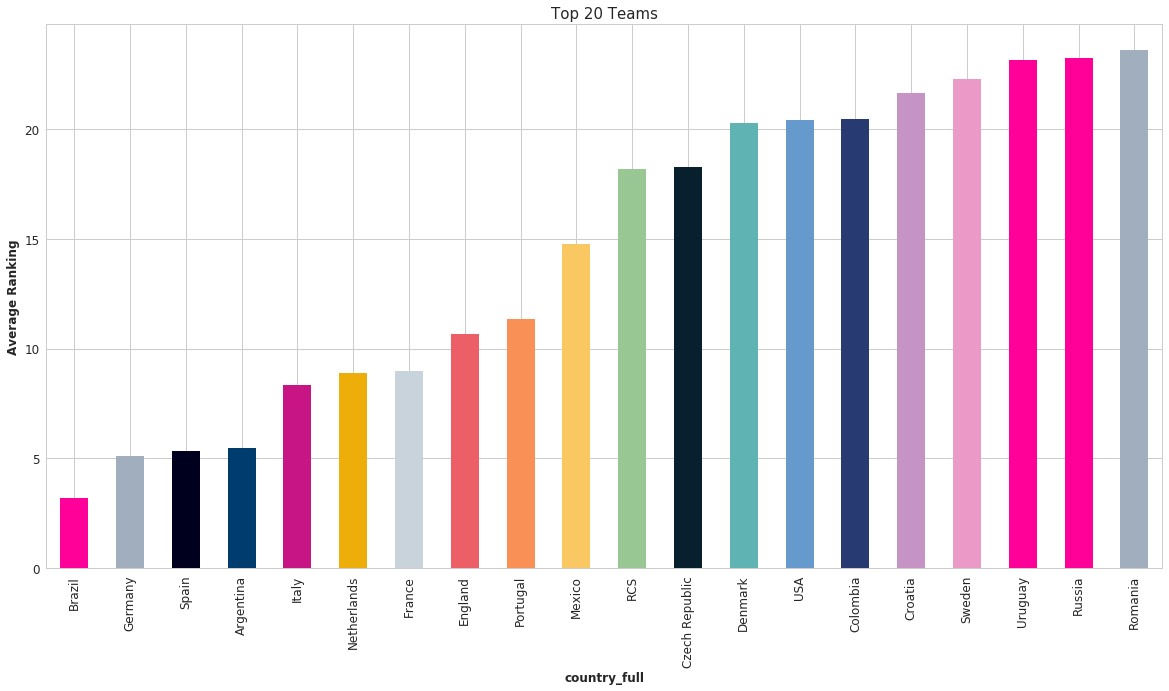

In [7]:
# Click to Expand
rankings.groupby('country_full').mean().sort_values('rank').head(20)['rank'].plot(kind='bar',figsize=(20,10))
plt.title('Top 20 Teams')
plt.ylabel('Average Ranking')

Text(0,0.5,'Stddev Ranking')

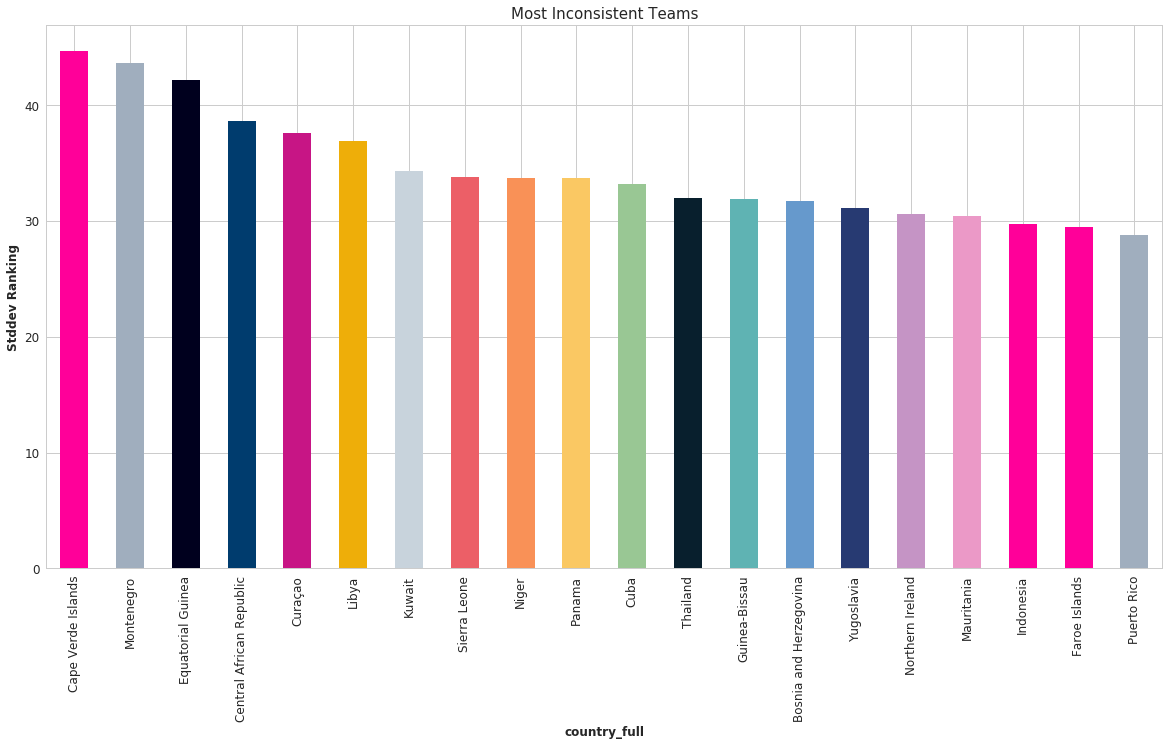

In [10]:
# Click to Expand
rankings.groupby('country_full').std().sort_values('rank',ascending=False).head(20)['rank'].plot(kind='bar',figsize=(20,10))
plt.title('Most Inconsistent Teams')
plt.ylabel('Stddev Ranking')

In [11]:
#click to expand
import ipywidgets as widgets

team1 = widgets.Dropdown(
    options=rankings.country_full.unique(),
    value='England',
    description='X Axis:',
    disabled=False
)

team2 = widgets.Dropdown(
    options=rankings.country_full.unique(),
    value='Spain',
    description='Y Axis:',
    disabled=False
)

items = [team1,team2]
widgets.HBox(items)

HBox(children=(Dropdown(description='X Axis:', index=10, options=('Germany', 'Italy', 'Switzerland', 'Sweden', 'Argentina', 'Republic of Ireland', 'Russia', 'Brazil', 'Norway', 'Denmark', 'England', 'France', 'Spain', 'Mexico', 'RCS', 'Netherlands', 'Nigeria', 'Belgium', 'Colombia', 'Poland', 'Romania', 'Uruguay', 'Portugal', 'Cameroon', 'Zambia', 'Egypt', 'Wales', 'USA', "Côte d'Ivoire", 'Scotland', 'Tunisia', 'Greece', 'Morocco', 'Algeria', 'Ecuador', 'Korea Republic', 'Bulgaria', 'Austria', 'Costa Rica', 'Northern Ireland', 'Honduras', 'Hungary', 'Japan', 'Saudi Arabia', 'China PR', 'Canada', 'Finland', 'Ghana', 'Chile', 'Zimbabwe', 'Qatar', 'Australia', 'Iceland', 'Iran', 'United Arab Emirates', 'Yugoslavia', 'Iraq', 'Senegal', 'Bolivia', 'Kuwait', 'Korea DPR', 'El Salvador', 'Turkey', 'Gabon', 'Guinea', 'Thailand', 'Paraguay', 'Malawi', 'Israel', 'Peru', 'Zaire', 'Cyprus', 'Singapore', 'Mali', 'Malaysia', 'Bermuda', 'Niger', 'Syria', 'Bahrain', 'New Zealand', 'Madagascar', 'Malta', 'Jamaica', 'Lithuania', 'Trinidad and Tobago', 'Sierra Leone', 'Jordan', 'Kenya', 'Latvia', 'Yemen', 'Tanzania', 'Albania', 'Angola', 'Venezuela', 'Ethiopia', 'Burundi', 'Oman', 'Indonesia', 'Liberia', 'Mozambique', 'Puerto Rico', 'Swaziland', 'Hong Kong', 'Uganda', 'Barbados', 'Myanmar', 'Congo', 'Lebanon', 'South Africa', 'Luxembourg', 'Faroe Islands', 'Guatemala', 'Burkina Faso', 'Togo', 'Suriname', 'Fiji', 'Croatia', 'Estonia', 'San Marino', 'Bangladesh', 'St Vincent and the Grenadines', 'Netherlands Antilles', 'Mauritius', 'Benin', 'Panama', 'Sudan', 'Antigua and Barbuda', 'Slovenia', 'India', 'Belarus', 'Ukraine', 'Vietnam', 'Guinea-Bissau', 'Guyana', 'Botswana', 'St Lucia', 'Tahiti', 'Grenada', 'Haiti', 'Libya', 'Laos', 'Mauritania', 'Cape Verde Islands', 'Solomon Islands', 'Brunei Darussalam', 'Lesotho', 'Dominican Republic', 'Pakistan', 'Nicaragua', 'Cuba', 'Seychelles', 'Central African Republic', 'Gambia', 'Namibia', 'Cayman Islands', 'Nepal', 'Liechtenstein', 'Equatorial Guinea', 'Chinese Taipei', 'Sri Lanka', 'Philippines', 'Chad', 'Vanuatu', 'Aruba', 'Bahamas', 'Maldives', 'Macau', 'Slovakia', 'St Kitts and Nevis', 'Czech Republic', 'Georgia', 'FYR Macedonia', 'Moldova', 'Armenia', 'Azerbaijan', 'Uzbekistan', 'Turkmenistan', 'Kazakhstan', 'Tajikistan', 'Kyrgyz Republic', 'Somalia', 'Djibouti', 'Dominica', 'Rwanda', 'Belize', 'Cambodia', 'Bosnia and Herzegovina', 'Guam', 'Papua New Guinea', 'Tonga', 'Samoa', 'Andorra', 'Cook Islands', 'British Virgin Islands', 'Anguilla', 'São Tomé e Príncipe', 'Eritrea', 'American Samoa', 'Palestine', 'Mongolia', 'Turks and Caicos Islands', 'US Virgin Islands', 'Montserrat', 'Congo DR', 'Bhutan', 'Serbia and Montenegro', 'Afghanistan', 'New Caledonia', 'Serbia', 'Timor-Leste', 'Comoros', 'Montenegro', 'Curaçao', 'South Sudan', 'Kosovo', 'Gibraltar'), value='England'), Dropdown(description='Y Axis:', index=12, options=('Germany', 'Italy', 'Switzerland', 'Sweden', 'Argentina', 'Republic of Ireland', 'Russia', 'Brazil', 'Norway', 'Denmark', 'England', 'France', 'Spain', 'Mexico', 'RCS', 'Netherlands', 'Nigeria', 'Belgium', 'Colombia', 'Poland', 'Romania', 'Uruguay', 'Portugal', 'Cameroon', 'Zambia', 'Egypt', 'Wales', 'USA', "Côte d'Ivoire", 'Scotland', 'Tunisia', 'Greece', 'Morocco', 'Algeria', 'Ecuador', 'Korea Republic', 'Bulgaria', 'Austria', 'Costa Rica', 'Northern Ireland', 'Honduras', 'Hungary', 'Japan', 'Saudi Arabia', 'China PR', 'Canada', 'Finland', 'Ghana', 'Chile', 'Zimbabwe', 'Qatar', 'Australia', 'Iceland', 'Iran', 'United Arab Emirates', 'Yugoslavia', 'Iraq', 'Senegal', 'Bolivia', 'Kuwait', 'Korea DPR', 'El Salvador', 'Turkey', 'Gabon', 'Guinea', 'Thailand', 'Paraguay', 'Malawi', 'Israel', 'Peru', 'Zaire', 'Cyprus', 'Singapore', 'Mali', 'Malaysia', 'Bermuda', 'Niger', 'Syria', 'Bahrain', 'New Zealand', 'Madagascar', 'Malta', 'Jamaica', 'Lithuania', 'Trinidad and Tobago', 'Sierra Leone', 'Jordan', 'Kenya', 'Latvia', 'Yemen', 'Tanzania', 'Albania', 'Angola', 'Venezuela', 'Ethiopia', 'Buru

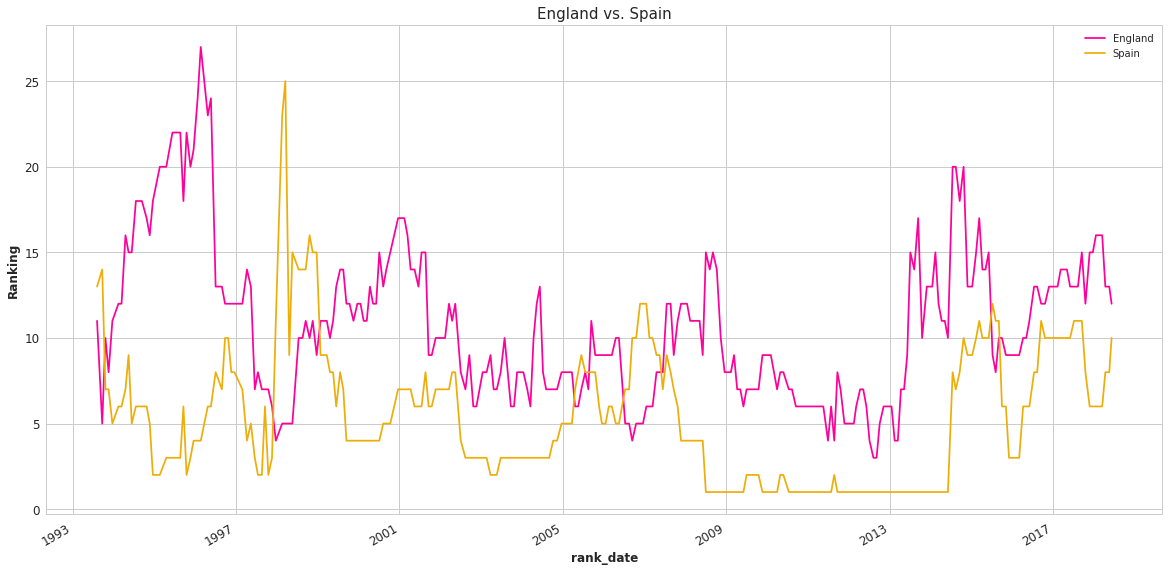

In [192]:
# Click to Expand
rankings.query("country_full == '%s'" % team1.value).groupby(['rank_date']).mean()['rank'].plot(figsize=(20,10))
rankings.query("country_full == '%s'" % team2.value).groupby(['rank_date']).mean()['rank'].plot(c=color_dict['gold'])
plt.title('%s vs. %s' % (team1.value,team2.value))
plt.ylabel('Ranking')
plt.legend([team1.value,team2.value])

# Results

Largest goal difference ? 

In [12]:
matches.query(' abs(home_score - away_score) ==  %i ' % np.max(np.abs(matches.home_score - matches.away_score)))

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
23569,2001-04-11,Australia,American Samoa,31,0,FIFA World Cup qualification,Coffs Harbour,Australia,False


Teams with highest draw rates ? 

Text(0,0.5,'% of matches drawn')

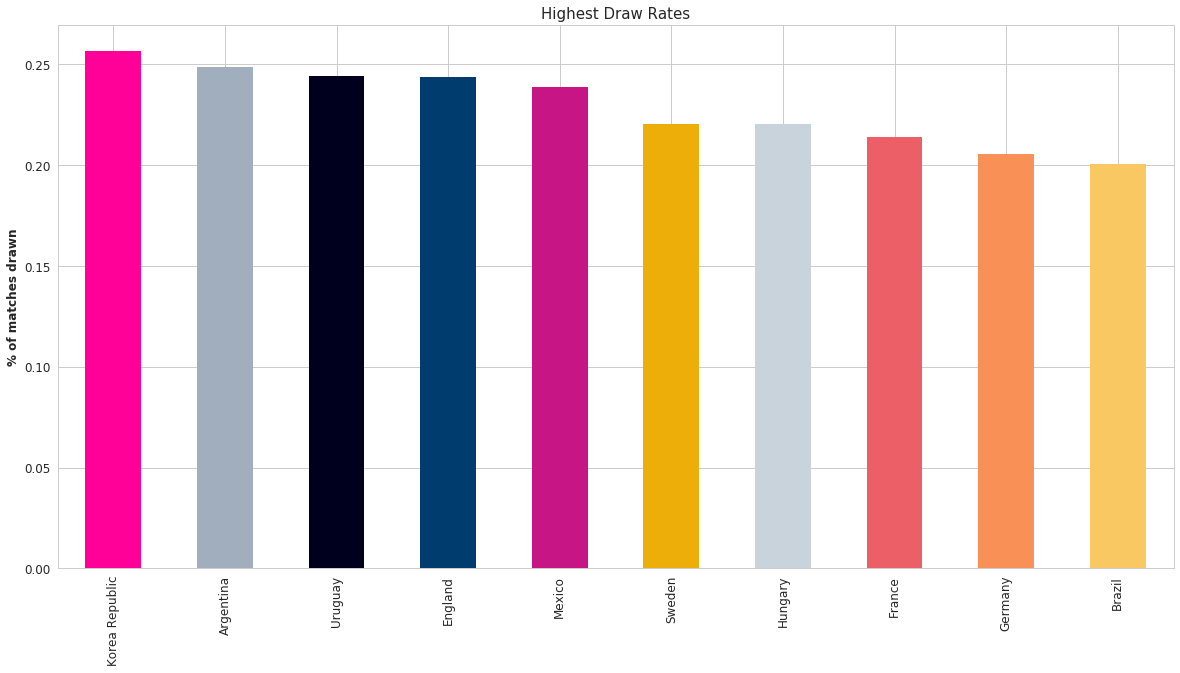

In [14]:
matches['spread'] = np.abs(matches.home_score - matches.away_score)
((matches.query('spread == 0 ').groupby('home_team').count()['date'] + matches.query('spread == 0 ').groupby('away_team').count()['date'])/((matches.groupby('home_team').count()['date'] + matches.groupby('away_team').count()['date'])).sort_values(ascending=False).head(10)
).sort_values(ascending=False).head(10).plot(kind='bar',figsize=(20,10))
plt.title('Highest Draw Rates')
plt.ylabel('% of matches drawn')

Text(0,0.5,'% of matches one by more than 1 goal')

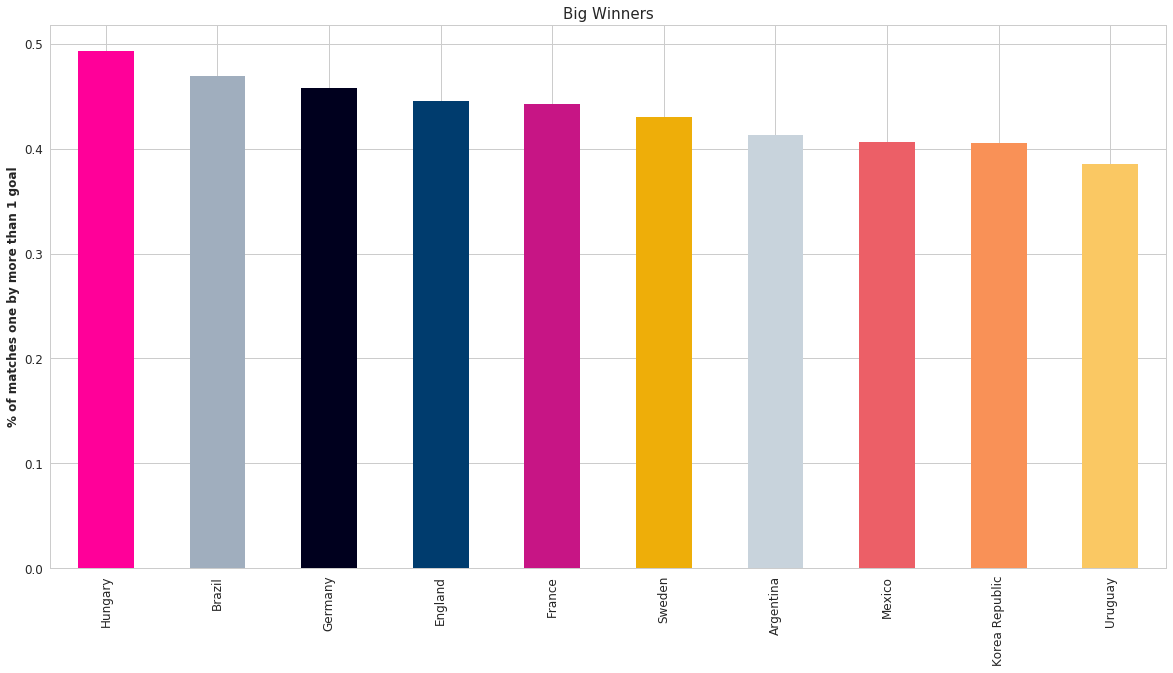

In [15]:
matches['spread'] = np.abs(matches.home_score - matches.away_score)
((matches.query('spread > 1 ').groupby('home_team').count()['date'] + matches.query('spread > 1 ').groupby('away_team').count()['date'])/((matches.groupby('home_team').count()['date'] + matches.groupby('away_team').count()['date'])).sort_values(ascending=False).head(10)
).sort_values(ascending=False).head(10).plot(kind='bar',figsize=(20,10))
plt.title('Big Winners')
plt.ylabel('% of matches one by more than 1 goal')

# Predicting Results 

In order to be able to predict the result of WC2018 we need to be able to predict a head2head's. There are several algorythims we could look at but before we do we need to create a dataset.

* Days between matches
* Home and Away teams rankings
* Rolling average of home and away teams rankings
* Rolling average of goals per match weighted by oppositions ranking
* Importance of match

In [16]:
# Click to Expand
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
            
# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 
matches['is_stake'] = matches['tournament'] != 'Friendly'


# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

matches['home_goal_value'] = matches['home_score']*(1/matches['rank_away'])
matches['away_goal_value'] = matches['away_score']*(1/matches['rank_home'])

def goal_val(row):
    row['home_goal_value'] = row['home_goal_value']*0.8
    row['away_goal_value'] = row['away_goal_value']*1.2
    
    return row

matches = matches.apply(goal_val, axis=1)

attaching_df = pd.concat([matches.groupby(['home_team','date']).mean()['home_goal_value'].reset_index().rename(columns={
    'home_team' : 'team',
    'home_goal_value' : 'attacking_momentum'
})                       
,matches.groupby(['away_team','date']).mean()['away_goal_value'].reset_index().rename(columns={
    'away_team' : 'team',
    'away_goal_value' : 'attacking_momentum'
})]).sort_values(['team','date'])

attaching_df = attaching_df.set_index(['date'])\
            .groupby(['team'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
            
attaching_df['attacking_momentum'] = attaching_df.groupby('team').shift(-1)
attaching_df['attacking_momentum'] = pd.rolling_mean(attaching_df['attacking_momentum'],window=14)

matches['home_goal_value'] = matches['away_score']*(matches['rank_home'])/100
matches['away_goal_value'] = matches['home_score']*(matches['rank_away'])/100

def goal_val(row):
    if row['is_stake'] == False:
        row['home_goal_value'] = row['home_goal_value']*0.6
        row['away_goal_value'] = row['away_goal_value']*0.8
    
    return row

matches = matches.apply(goal_val, axis=1)

defensive_df = pd.concat([matches.groupby(['home_team','date']).mean()['home_goal_value'].reset_index().rename(columns={
    'home_team' : 'team',
    'home_goal_value' : 'defense_momentum'
})
,matches.groupby(['away_team','date']).mean()['away_goal_value'].reset_index().rename(columns={
    'away_team' : 'team',
    'away_goal_value' : 'defense_momentum'
})]).sort_values(['team','date'])

defensive_df = defensive_df.set_index(['date'])\
            .groupby(['team'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
            
defensive_df['defense_momentum'] = defensive_df.groupby('team')['defense_momentum'].shift(-1)
defensive_df['defense_momentum'] = pd.rolling_mean(defensive_df['defense_momentum'],window=14)

# join the ranks
matches = matches.merge(defensive_df, 
                        left_on=['date', 'home_team'], 
                        right_on=['date', 'team'])

matches = matches.merge(attaching_df, 
                        left_on=['date', 'home_team'], 
                        right_on=['date', 'team'])

rolling_ranking_df = pd.concat([matches.groupby(['home_team','date']).mean()['rank_home'].reset_index().rename(columns={
    'home_team' : 'team',
    'rank_home' : 'ranking_rolling'
})                       
,matches.groupby(['away_team','date']).mean()['rank_away'].reset_index().rename(columns={
    'away_team' : 'team',
    'away_goal_value' : 'ranking_rolling'
})]).sort_values(['team','date'])


rolling_ranking_df = rolling_ranking_df.set_index(['date'])\
            .groupby(['team'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
            
rolling_ranking_df['ranking_rolling'] = rolling_ranking_df.groupby('team')['ranking_rolling'].shift(-1)
rolling_ranking_df['ranking_rolling_a'] = pd.rolling_mean(rolling_ranking_df['ranking_rolling'],window=365)
rolling_ranking_df['ranking_rolling_h'] = rolling_ranking_df['ranking_rolling_a']


# join the ranks
matches = matches.merge(rolling_ranking_df[['date', 'team','ranking_rolling_h']], 
                        left_on=['date', 'home_team'], 
                        right_on=['date', 'team'])

matches = matches.merge(rolling_ranking_df[['date', 'team','ranking_rolling_a']], 
                        left_on=['date', 'away_team'], 
                        right_on=['date', 'team'])

matches = matches[[
 'date', 'home_team', 'away_team', 'home_score', 'away_score',
       'spread',
       'rank_home', 
       'rank_away', 
       'rank_difference', 
        'score_difference', 
        'is_won',
       'is_stake', 
       'rest_days', 
        'defense_momentum',
        'attacking_momentum',
    'ranking_rolling_a',
    'ranking_rolling_h'
]].set_index('date').ix['2000-01-01':]



matches.dropna(inplace=True)

matches.head(10).T

date,2000-01-04 00:00:00,2000-01-07 00:00:00,2000-01-08 00:00:00,2000-01-09 00:00:00,2000-01-09 00:00:00,2000-01-09 00:00:00,2000-01-11 00:00:00,2000-01-11 00:00:00,2000-01-13 00:00:00,2000-01-14 00:00:00
home_team,Egypt,Tunisia,Trinidad and Tobago,Burkina Faso,Guatemala,Mexico,Bermuda,Burkina Faso,Senegal,China PR
away_team,Togo,Togo,Canada,Gabon,Armenia,Iran,Canada,Cameroon,Cameroon,New Zealand
home_score,2,7,0,1,1,2,0,2,0,1
away_score,1,0,0,1,1,1,2,2,0,0
spread,1,7,0,0,0,1,2,0,0,1
rank_home,38,31,44,71,73,10,163,71,79,88
rank_away,87,87,81,74,85,49,81,58,58,100
rank_difference,-49,-56,-37,-3,-12,-39,82,13,21,-12
score_difference,1,7,0,0,0,1,-2,0,0,1
is_won,True,True,False,False,False,True,False,False,False,True


## Answer some questions

If we pick the highest ranked team to win how accurate will our predictions be? 

In [197]:
(len(matches.query("is_won == True and rank_difference < 0")) + len(matches.query("is_won == False and rank_difference > 0")))/len(matches)

0.6706404214028279

If we pick the highest ranked team to win just and exclude friendlys how accurate will our predictions be? 

In [198]:
(len(matches.query("is_won == True and rank_difference < 0 and is_stake == True")) + len(matches.query("is_won == False and is_stake == True and rank_difference > 0")))/len(matches.query("is_stake == True"))

0.7018549747048903

If we pick the highest ranked team to win except with lower ranked team current ranking is higher than their avergage ranking of the last 12 months. And exclude friendlys and  how accurate will our predictions be? 

In [199]:

(len(matches.query("is_won == True and  (rank_difference < 0 or rank_away <= ranking_rolling_a) and is_stake == True")) + len(matches.query("is_won == False and is_stake == True and  (rank_difference > 0 or rank_home <= ranking_rolling_h )")))/len(matches.query("is_stake == True"))


0.8608206857785272

In [17]:
matches['rank_rise_a'] =  matches['rank_away'] - matches['ranking_rolling_a']
matches['rank_rise_h'] =  matches['rank_away'] - matches['ranking_rolling_a']
matches['rise_delta'] = matches['rank_rise_h'] - matches['rank_rise_a']

Is it better to be an attacking or defending team? 

Text(0.5,1,'Average Attacking Momentum')

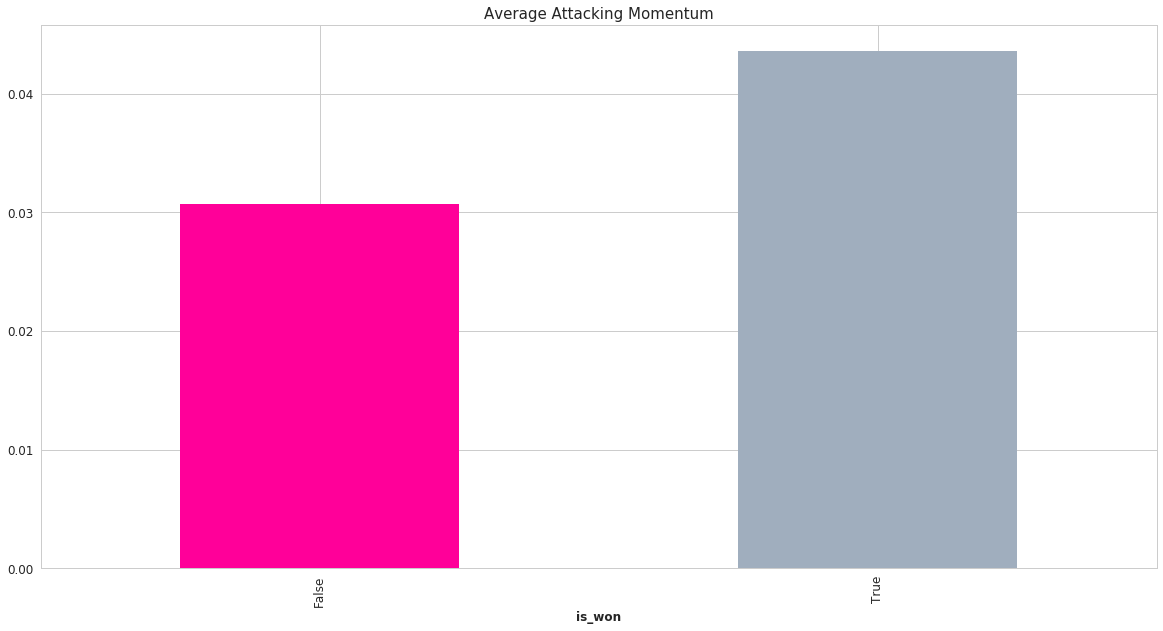

In [31]:
matches.query("is_stake==True").groupby('is_won').mean()['attacking_momentum'].plot(kind='bar',figsize=(20,10))
plt.title('Average Attacking Momentum')

Text(0.5,1,'Average Defense Momentum')

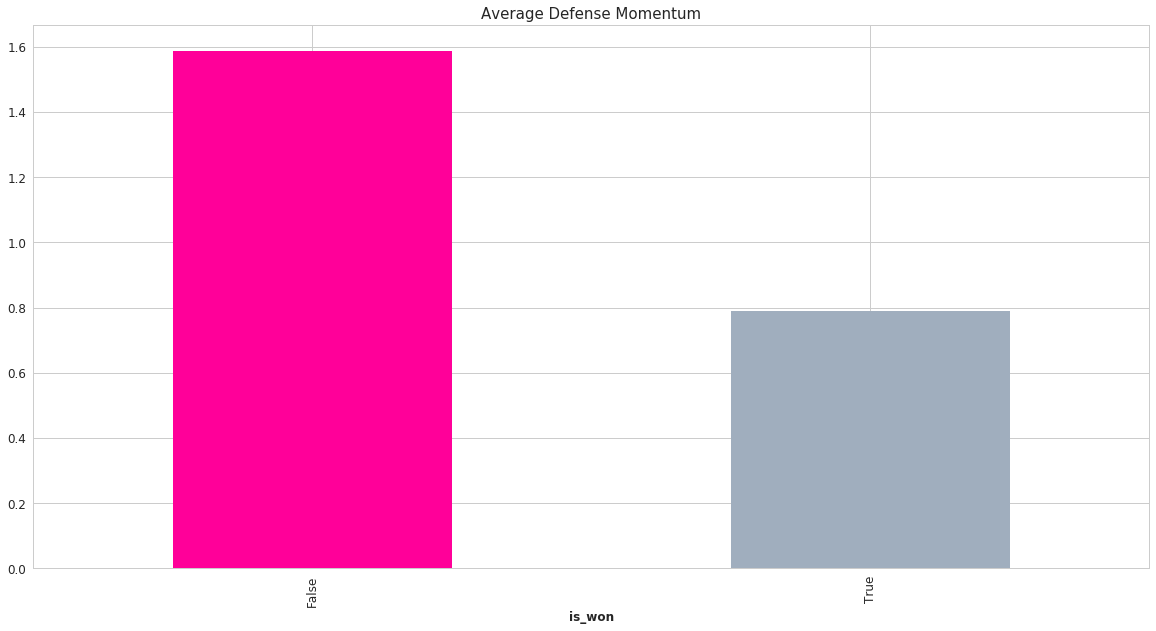

In [32]:
matches.query("is_stake==True").groupby('is_won').mean()['defense_momentum'].plot(kind='bar',figsize=(20,10))
plt.title('Average Defense Momentum')

In [47]:
attack_mom = matches.query("is_stake==True").groupby('is_won').mean()['defense_momentum'].values[0] - \
matches.query("is_stake==True").groupby('is_won').mean()['defense_momentum'].values[1]


def_mom = matches.query("is_stake==True").groupby('is_won').mean()['attacking_momentum'].values[0] - \
matches.query("is_stake==True").groupby('is_won').mean()['attacking_momentum'].values[1]

print(attack_mom/def_mom)

-61.6965206534


In [48]:
def_mom

-0.012945839861390616

## Logistic Regression 

The Logistic Regression provided a reasonable uplift on randomly guessing with an AUC score of 0.74 with FIFA ranking and rolling count of points difference providing the most predictive features 

In [202]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.query("is_stake == True").loc[:,['rank_home', 'rank_difference', 'defense_momentum', 'attacking_momentum','rise_delta']], matches.query("is_stake == True")['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [203]:
# Click to expand
logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)

model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])

model = model.fit(X_train, y_train)


Text(0.5,1,'AUC score is 0.77')

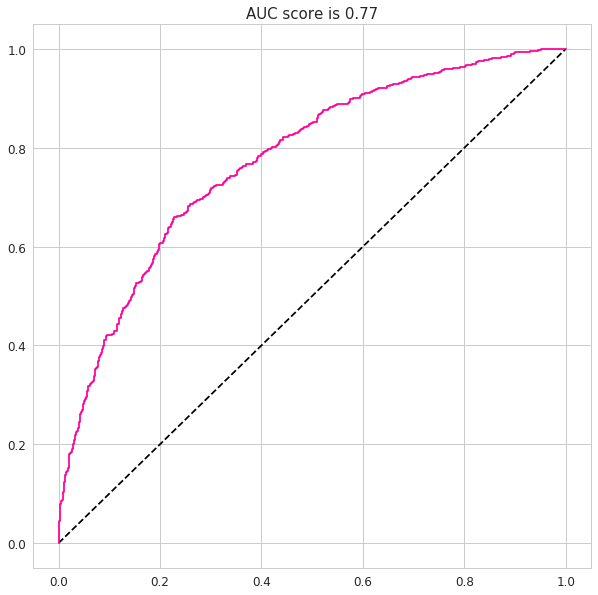

In [204]:
# Click to expand
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

## XgBoost

The XgBoost solution proved to be the better options with a marginally better score of 0.76 while this may not seem like a significant difference once we looking into our simulations we can see it does have a significant impact.

In [205]:
X['attacking_momentum'] = pd.to_numeric(X['attacking_momentum'] )
X_test['attacking_momentum'] = pd.to_numeric(X_test['attacking_momentum'] )


Text(0.5,1,'AUC score is 0.92')

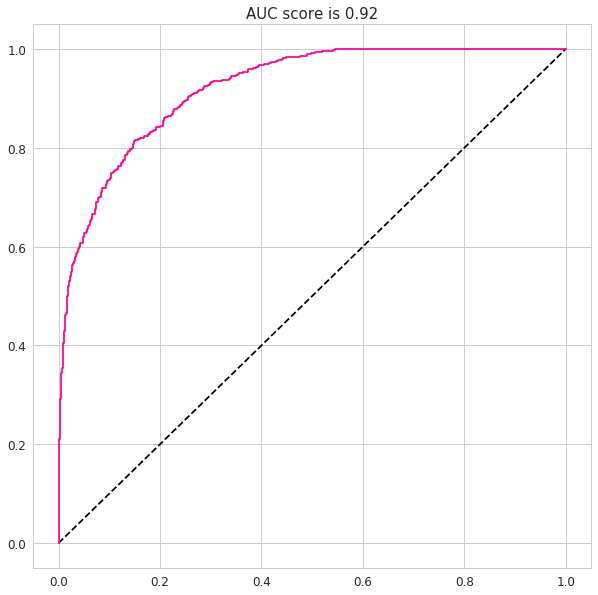

In [206]:
#Click to Expand
dtrain = xgb.DMatrix(X, label=y, missing=0)
dval = xgb.DMatrix(X_test,label=y_test)
evallist = [(dval,'eval'),(dtrain,'train')]

param = { 
    'silent':1, 
    'objective':'reg:logistic', 
    'booster':'gbtree', 
    'eval_metric' : 'auc',
    'rate_drop' :0.10,
    'max_depth' : 5
}

num_round = 100
bts = xgb.train(param, dtrain, num_round,evallist,early_stopping_rounds=5,verbose_eval=False)

test = pd.DataFrame()
train = pd.DataFrame()

dtrain = xgb.DMatrix(X, label=y, missing=0)
dval = xgb.DMatrix(X_test,label=y_test)

train['trend'] = y
test['trend'] = y_test

test['pred'] = bts.predict(dval)
train['pred'] = bts.predict(dtrain)

# Click to expand
fpr, tpr, _ = roc_curve(y_test, test['pred'])
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, test['pred'] )))


# World Cup Simmulation

Using both our models we run a simmulation of The World Cup

## Logistic Regression 

In [207]:
matches.reset_index(inplace=True)

In [208]:
latest_attack = attaching_df.groupby('team').tail(2).dropna().set_index('team')['attacking_momentum']
latest_def = defensive_df.groupby('team').tail(2).dropna().set_index('team')['defense_momentum']

In [210]:
rank_rise = pd.concat([matches.groupby('home_team').tail(1)[['date','home_team','rank_rise_h']].rename(columns={
  'home_team' : 'team' ,
  'rank_rise_h' : 'rank_rise' 

}),
matches.groupby('away_team').tail(1)[['date','away_team','rank_rise_a']].rename(columns={
  'away_team' : 'team',
  'rank_rise_a' : 'rank_rise' 
})]).sort_values(['team','date']).groupby('team').head(1)
rank_rise = rank_rise.set_index('team')['rank_rise']

In [211]:
# Click to Expand


world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])


from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0


for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan,np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        
        row['defense_momentum'] = latest_def.ix[home]
        row['attacking_momentum'] = latest_attack.ix[home]
        
        row['rise_delta'] = rank_rise.ix[home] - rank_rise.ix[away]
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['defense_momentum'] = latest_def.ix[home]
        row['attacking_momentum'] = latest_attack.ix[home]
        row['rise_delta'] = rank_rise.ix[home] - rank_rise.ix[away]

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1][0] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")
    


___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.56
Russia vs. Egypt: Egypt wins with 0.65
Russia vs. Uruguay: Uruguay wins with 0.76
Saudi Arabia vs. Egypt: Egypt wins with 0.64
Saudi Arabia vs. Uruguay: Uruguay wins with 0.74
Egypt vs. Uruguay: Uruguay wins with 0.66
___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.56
Argentina vs. Croatia: Argentina wins with 0.55
Argentina vs. Nigeria: Argentina wins with 0.67
Iceland vs. Croatia: Draw
Iceland vs. Nigeria: Iceland wins with 0.59
Croatia vs. Nigeria: Croatia wins with 0.60
___Starting group F:___
Germany vs. Mexico: Germany wins with 0.55
Germany vs. Sweden: Germany wins with 0.59
Germany vs. Korea Republic: Germany wins with 0.72
Mexico vs. Sweden: Draw
Mexico vs. Korea Republic: Mexico wins with 0.66
Sweden vs. Korea Republic: Sweden wins with 0.61
___Starting group C:___
France vs. Australia: France wins with 0.61
France vs. Peru: Draw
France vs. Denmark: Draw
Australia vs. Peru: Peru 

## XgBoost

In [212]:
# Click to Expand

world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')


margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])


from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        
        row['defense_momentum'] = latest_def.ix[home]
        row['attacking_momentum'] = latest_attack.ix[home]
        row['rise_delta'] = rank_rise.ix[home] - rank_rise.ix[away]

        home_win_prob = bts.predict(xgb.DMatrix(row))[0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['defense_momentum'] = latest_def.ix[home]
        row['attacking_momentum'] = latest_attack.ix[home]
        row['rise_delta'] = rank_rise.ix[home] - rank_rise.ix[away]

            
        home_win_prob = bts.predict(xgb.DMatrix(row))[0]
        if bts.predict(xgb.DMatrix(row))[0] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")
    


___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.66
Russia vs. Egypt: Egypt wins with 0.71
Russia vs. Uruguay: Uruguay wins with 0.87
Saudi Arabia vs. Egypt: Egypt wins with 0.59
Saudi Arabia vs. Uruguay: Uruguay wins with 0.60
Egypt vs. Uruguay: Uruguay wins with 0.87
___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.60
Argentina vs. Croatia: Draw
Argentina vs. Nigeria: Draw
Iceland vs. Croatia: Croatia wins with 0.73
Iceland vs. Nigeria: Nigeria wins with 0.59
Croatia vs. Nigeria: Croatia wins with 0.76
___Starting group F:___
Germany vs. Mexico: Mexico wins with 0.80
Germany vs. Sweden: Sweden wins with 0.58
Germany vs. Korea Republic: Germany wins with 0.85
Mexico vs. Sweden: Sweden wins with 0.98
Mexico vs. Korea Republic: Korea Republic wins with 0.81
Sweden vs. Korea Republic: Korea Republic wins with 1.00
___Starting group C:___
France vs. Australia: France wins with 0.88
France vs. Peru: Peru wins with 0.63
France vs. Denmark: Denmar